# Bharath Gunasekaran
MMoE multi task learning model

https://github.com/drawbridge/keras-mmoe

In [2]:
! mkdir Mmoe/
! touch Mmoe/__init__.py
!wget https://raw.githubusercontent.com/drawbridge/keras-mmoe/master/mmoe.py -O /content/Mmoe/mmoe.py

--2021-11-10 03:05:38--  https://raw.githubusercontent.com/drawbridge/keras-mmoe/master/mmoe.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11077 (11K) [text/plain]
Saving to: ‘/content/Mmoe/mmoe.py’

/content/Mmoe/mmoe. 100%[===================>]  10.82K  --.-KB/s    in 0s      

2021-11-10 03:05:39 (86.1 MB/s) - ‘/content/Mmoe/mmoe.py’ saved [11077/11077]



In [45]:
import random

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Mmoe.mmoe import MMoE
import matplotlib.pyplot as plt


# Set Intial Parameters

In [4]:
SEED = 1

np.random.seed(SEED)

random.seed(SEED)

tf.random.set_seed(SEED)

# Dataset Generation

In [50]:
def data_preparation():
    # Randomly Generating Data 
    num_dimension = 100
    num_row = 5000
    c = 0.3
    rho = 0.8
    m = 5

    mu1 = np.random.normal(size=num_dimension)
    mu1 = (mu1 - np.mean(mu1)) / (np.std(mu1) * np.sqrt(num_dimension))
    mu2 = np.random.normal(size=num_dimension)
    mu2 -= mu2.dot(mu1) * mu1
    mu2 /= np.linalg.norm(mu2)
    w1 = c * mu1
    w2 = c * (rho * mu1 + np.sqrt(1. - rho ** 2) * mu2)

    # Feature and label generation
    alpha = np.random.normal(size=m)
    beta = np.random.normal(size=m)
    y0 = []
    y1 = []
    X = []

    for i in range(num_row):
        x = np.random.normal(size=num_dimension)
        X.append(x)
        num1 = w1.dot(x)
        num2 = w2.dot(x)
        comp1, comp2 = 0.0, 0.0

        for j in range(m):
            comp1 += np.sin(alpha[j] * num1 + beta[j])
            comp2 += np.sin(alpha[j] * num2 + beta[j])

        y0.append(num1 + comp1 + np.random.normal(scale=0.1, size=1))
        y1.append(num2 + comp2 + np.random.normal(scale=0.1, size=1))
    X = np.array(X)
    data = pd.DataFrame(
        data=X,
        index=range(X.shape[0]),
        columns=['x{}'.format(it) for it in range(X.shape[1])]
    )

    data['y0'] = np.array(y0)
    data['y1'] = np.array(y1)

    features = data.drop(columns=['y0','y1'])
    labels = data[['y0','y1']]

    train_data = features.iloc[0:3500]
    train_label =  labels.iloc[0:3500]

    validation_data = features.iloc[3500:4500]
    validation_label = labels.iloc[3500:4500]
    test_data = features.iloc[4500:]
    test_label = labels.iloc[4500:]
    return train_data, train_label , validation_data, validation_label, test_data, test_label

# Load Dataset

In [57]:
train_data, train_label, validation_data, validation_label, test_data, test_label = data_preparation()
num_features = train_data.shape[1]

print('Training data shape = {}'.format(train_data.shape))
print('Training data shape = {}'.format(train_label.shape))

print('Validation data shape = {}'.format(validation_data.shape))
print('Test data shape = {}'.format(test_data.shape))

Training data shape = (3500, 100)
Training data shape = (3500, 2)
Validation data shape = (1000, 100)
Test data shape = (500, 100)


# Model Creation

In [58]:
# Set up the input layer
input_layer = Input(shape=(num_features,))

# Set up MMoE layer
mmoe_layers = MMoE(
    units=16,
    num_experts=8,
    num_tasks=2
)(input_layer)

output_layers = []

output_info = ['y0', 'y1']

# Build tower layer from MMoE layer
for index, task_layer in enumerate(mmoe_layers):
    tower_layer = Dense(
        units=8,
        activation='relu',
        kernel_initializer=VarianceScaling())(task_layer)
    output_layer = Dense(
        units=1,
        name=output_info[index],
        activation='linear',
        kernel_initializer=VarianceScaling())(tower_layer)
    output_layers.append(output_layer)

# Compile model
model = Model(inputs=[input_layer], outputs=output_layers)
learning_rates = [1e-4, 1e-3, 1e-2]
adam_optimizer = Adam(lr=learning_rates[0])
model.compile(
    loss={'y0': 'mean_squared_error', 'y1': 'mean_squared_error'},
    optimizer=adam_optimizer,
    metrics=[metrics.mae]
)

# Print out model architecture summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 m_mo_e_7 (MMoE)                [(None, 16),         14544       ['input_8[0][0]']                
                                 (None, 16)]                                                      
                                                                                                  
 dense_14 (Dense)               (None, 8)            136         ['m_mo_e_7[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 8)            136         ['m_mo_e_7[0][1]']         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training Model 

Epoch 1/20
110/110 [==============================] - 2s 7ms/step - loss: 0.3588 - y0_loss: 0.1752 - y1_loss: 0.1837 - y0_mean_absolute_error: 0.3380 - y1_mean_absolute_error: 0.3458 - val_loss: 0.3168 - val_y0_loss: 0.1604 - val_y1_loss: 0.1564 - val_y0_mean_absolute_error: 0.3182 - val_y1_mean_absolute_error: 0.3153
Epoch 2/20
110/110 [==============================] - 0s 3ms/step - loss: 0.2924 - y0_loss: 0.1544 - y1_loss: 0.1380 - y0_mean_absolute_error: 0.3169 - y1_mean_absolute_error: 0.2987 - val_loss: 0.2628 - val_y0_loss: 0.1411 - val_y1_loss: 0.1217 - val_y0_mean_absolute_error: 0.2979 - val_y1_mean_absolute_error: 0.2775
Epoch 3/20
110/110 [==============================] - 0s 3ms/step - loss: 0.2364 - y0_loss: 0.1319 - y1_loss: 0.1045 - y0_mean_absolute_error: 0.2923 - y1_mean_absolute_error: 0.2590 - val_loss: 0.2132 - val_y0_loss: 0.1194 - val_y1_loss: 0.0939 - val_y0_mean_absolute_error: 0.2736 - val_y1_mean_absolute_error: 0.2437
Epoch 4/20
110/110 [====================

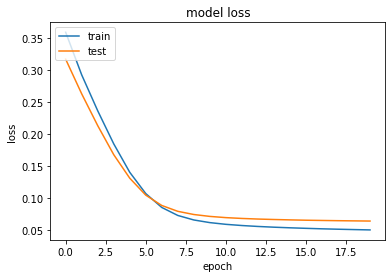

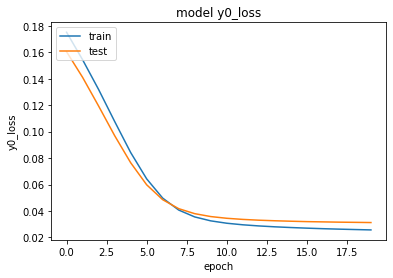

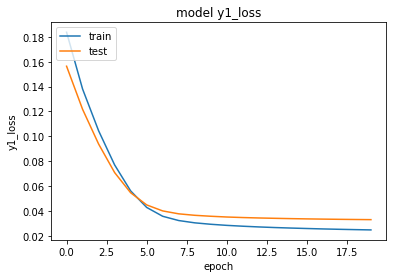

In [59]:
# Train the model
history = model.fit(
    x=train_data,
    y=train_label,
    validation_data=(validation_data, validation_label),
    epochs=20
)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['y0_loss'])
plt.plot(history.history['val_y0_loss'])
plt.title('model y0_loss')
plt.ylabel('y0_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['y1_loss'])
plt.plot(history.history['val_y1_loss'])
plt.title('model y1_loss')
plt.ylabel('y1_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()